# Analyze My Spotify Streaming History.

Main purpose of this project is to practicing data scraping and data manipulating with pandas(a little bit of visualization) with python language.

The data is my listening history which i requested from Spotify.
You can get yourself one from this link : https://www.spotify.com/us/account/privacy/

### Import data

In [1]:
import pandas as pd

In [2]:
spotify = pd.read_csv(r'C:\Users\Administrator\Desktop\project\spotify\Streaming_history.csv')

have a look at the data

In [3]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19503 entries, 0 to 19502
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     19503 non-null  object
 1   artistName  19503 non-null  object
 2   trackName   19503 non-null  object
 3   msPlayed    19503 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 609.6+ KB


In [4]:
print(spotify.head(5))

            endTime artistName                                    trackName  \
0  2020-02-07 05:50   ILLENIUM                                      Leaving   
1  2020-06-02 19:19      Nurko                                 Till the End   
2  2020-06-03 10:28      Ekali  Hard To Say Goodbye (feat. Chloe Angelides)   
3  2020-06-03 10:31      Ekali                         Leaving (feat. Yuna)   
4  2020-06-03 10:34      Ekali                                        Blame   

   msPlayed  
0    157614  
1    185490  
2    195817  
3    175851  
4      6351  


## Find genre for each artist.

Web Scraping method will be used to get genre data from each artist by get a tag element from  Last.fm website.

Before geting a tag of artist, I have to find a pattern of Url which can be used with every artist. I found that the pattern is https://www.last.fm/music/ followed by artist_name and the artist with multiple words will use '+' instead of spacing.

In [5]:
# make a list of artist name that replaced spacing with plus sign(+)
artists = []
for a in spotify['artistName']:
    a= a.replace(' ','+')
    if a not in artists :
        artists.append(a)
    else:
        pass

start web scraping.

In [6]:
import requests
from bs4 import BeautifulSoup

In [7]:
artist_tag ={}

for artist in artists:
    request_lastfm = requests.get('https://www.last.fm/music/'+artist)
    content_lastfm = request_lastfm.content
    lastfm = BeautifulSoup(content_lastfm,'html.parser')
    tags = lastfm.find_all("li",class_="tag")
    artist_tag[artist]=[]
    for t in tags:
        artist_tag[artist].append(t.text)
    artist_tag[artist].sort()

have a look at data.

In [8]:
import itertools
dict(itertools.islice(artist_tag.items(), 10))

{'ILLENIUM': ['dubstep',
  'edm',
  'electronic',
  'future bass',
  'melodic dubstep'],
 'Nurko': ['american',
  'dubstep',
  'electronic',
  'melodic bass',
  'united states'],
 'Ekali': ['chill trap', 'electronic', 'pop', 'rap', 'trap'],
 'Wafia': ['australian', 'chill pop', 'indie pop', 'pop', 'soul'],
 'RL+Grime': ['beats', 'electronic', 'experimental', 'trap'],
 'Kaivon': ['american',
  'chillwave',
  'electronic',
  'electronic superhighway',
  'united states'],
 'SLANDER': ['brostep', 'hardcore', 'heavy metal', 'nwobhm', 'thrash metal'],
 'Just+A+Gent': ['dubstep', 'electronic', 'fix with pro', 'lovetrap', 'trap'],
 'Jauz': ['electro', 'electronic', 'house', 'trap'],
 'DROELOE': ['discover weekly', 'dutch', 'electronic', 'future bass', 'trap']}

 Remove plus sign from Artist name.

In [9]:
artist_tag_fixed = {}
for a in artist_tag:
    artist_tag_fixed[a.replace('+',' ')] = artist_tag[a]

Some artists don't have tag and some have few which can be problem when make a table with this data.
Therefore,i add tag data with 'Null' instead until each of them have 5 tags (maximun amount of tags that the website can provide)

In [10]:
for a in artist_tag_fixed:
    while len(artist_tag_fixed[a]) <5:
        artist_tag_fixed[a].append('Null')
        if len(artist_tag_fixed[a]) == 5:
            break     

In [11]:
#Recheck for confirmation
check = 0
for a in artist_tag_fixed.keys():
    if ' ' in a:
        print(a)
        check +=  1
        if check == 10:
            break

RL Grime
Just A Gent
William Black
Jarryd James
Crystal Skies
Seven Lions
เหวย เหวย ฮัน
Mola Mola Sunshine!
Chilling Sunday
Tom Misch


### Create table with the data.

In [12]:
artist_tag_table = pd.DataFrame.from_dict(artist_tag_fixed,orient = 'index')
artist_tag_table.reset_index(inplace=True)
artist_tag_table.columns = ['artistName','tag_1','tag_2','tag_3','tag_4','tag_5']
artist_tag_table


,artistName,tag_1,tag_2,tag_3,tag_4,tag_5
0,ILLENIUM,dubstep,edm,electronic,future bass,melodic dubstep
1,Nurko,american,dubstep,electronic,melodic bass,united states
2,Ekali,chill trap,electronic,pop,rap,trap
3,Wafia,australian,chill pop,indie pop,pop,soul
4,RL Grime,beats,electronic,experimental,trap,Null
...,...,...,...,...,...,...
2209,The Devil Wears Prada,christian,christian metalcore,hardcore,metalcore,screamo
2210,Brief Audio Book,Null,Null,Null,Null,Null
2211,SPRITE,chillout,electronic,soundtrack,trap,wave
2212,OG BOBBY,Null,Null,Null,Null,Null


# Find my top 10 genre, artists, and songs


## Top 10 genre from artists

In [13]:
tag_dict={}
for a in artist_tag_table.iloc[:,1:6]:
    for b in artist_tag_table[a]:
        if b !='Null':
            if b in tag_dict :
                tag_dict[b] += 1
            else:
                tag_dict[b] = 1

dict(itertools.islice(tag_dict.items(), 10))

{'dubstep': 141,
 'american': 85,
 'chill trap': 3,
 'australian': 32,
 'beats': 22,
 'brostep': 30,
 'electro': 58,
 'discover weekly': 17,
 'dance': 119,
 'hard rock': 20}

In [14]:
top_tag = pd.DataFrame.from_dict(tag_dict,orient='index')
top_tag.columns = ['artists']
top_tag = top_tag.sort_values(by='artists',ascending=False)
top_tag.head(10)


,artists
electronic,528
pop,323
indie,250
hip-hop,194
house,170
ambient,155
rnb,151
rap,149
trap,144
dubstep,141


## Top 10 artists

In [15]:
most_listened = spotify.groupby('artistName')['msPlayed'].sum().sort_values(ascending=False).reset_index()
most_listened.set_index('artistName',inplace=True)
most_listened.head()

,msPlayed
artistName,
ILLENIUM,166965507
Seven Lions,85808451
Ekali,72334490
RL Grime,70939743
SLANDER,62385364


In [16]:
most_listened = pd.merge(most_listened,artist_tag_table,how='left',on = 'artistName')
most_listened = most_listened.iloc[:,:7]
most_listened['msPlayed'] = most_listened['msPlayed']/6000
most_listened.rename(columns={'msPlayed':'minutesPlayed'},inplace = True)
most_listened


,artistName,minutesPlayed,tag_1,tag_2,tag_3,tag_4,tag_5
0,ILLENIUM,27827.584500,dubstep,edm,electronic,future bass,melodic dubstep
1,Seven Lions,14301.408500,dubstep,electro house,electronic,house,trance
2,Ekali,12055.748333,chill trap,electronic,pop,rap,trap
3,RL Grime,11823.290500,beats,electronic,experimental,trap,Null
4,SLANDER,10397.560667,brostep,hardcore,heavy metal,nwobhm,thrash metal
...,...,...,...,...,...,...,...
2209,Skipit,0.000000,Null,Null,Null,Null,Null
2210,Jupi/ter,0.000000,Null,Null,Null,Null,Null
2211,8percent,0.000000,flowers and plants,numbers,sleep and dreams,Null,Null
2212,Middle Lane,0.000000,Null,Null,Null,Null,Null


## Top 10 Songs

In [17]:
top_songs = spotify.groupby('artistName')['trackName'].value_counts().sort_values(ascending=False)
top_songs = top_songs.to_frame()
top_songs.columns = ['number_playbacks']
top_songs

number_playbacks
artistName        trackName                                                     
ILLENIUM          Nightlight                                                 101
SLANDER           Potions                                                     89
RL Grime          Atoms - Said the Sky Remix                                  86
ILLENIUM          In Your Arms (with X Ambassadors)                           82
                  Sad Songs (& Said The Sky with Annika Wells)                81
...                                                                          ...
Jhené Aiko        Triggered - Remix                                            1
Jesus Molina      What Is This Thing Called Love                               1
                  Night in Tunisia                                             1
Jessica Audiffred This Ends Now                                                1
須田景凪              veil                                                         1

[6584 rows x 1 columns]

# Visualizations

find my favorite-time listening to spotify.

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [19]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19503 entries, 0 to 19502
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     19503 non-null  object
 1   artistName  19503 non-null  object
 2   trackName   19503 non-null  object
 3   msPlayed    19503 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 609.6+ KB


In [20]:
print(spotify['endTime'].head(10))
spotify['endTime'].tail(10)

0    2020-02-07 05:50
1    2020-06-02 19:19
2    2020-06-03 10:28
3    2020-06-03 10:31
4    2020-06-03 10:34
5    2020-06-03 10:34
6    2020-06-03 10:39
7    2020-06-03 10:42
8    2020-06-03 10:45
9    2020-06-03 10:48
Name: endTime, dtype: object


19493    2021-06-02 18:53
19494    2021-06-02 18:53
19495    2021-06-02 18:53
19496    2021-06-02 18:53
19497    2021-06-02 19:14
19498    2021-06-02 19:14
19499    2021-06-02 19:14
19500    2021-06-02 19:14
19501    2021-06-02 19:17
19502    2021-06-02 19:20
Name: endTime, dtype: object

In [21]:
spotify['endTime_Hour'] = pd.to_datetime(spotify['endTime']).dt.hour
spotify['endTime_Hour']

0         5
1        19
2        10
3        10
4        10
         ..
19498    19
19499    19
19500    19
19501    19
19502    19
Name: endTime_Hour, Length: 19503, dtype: int64

In [22]:
listen_time = spotify['endTime_Hour'].value_counts()
listen_time = listen_time.reset_index()
listen_time.columns = ['Hour','Song_counts']
listen_time = listen_time.sort_values(by='Hour')
listen_time



,Hour,Song_counts
21,0,364
23,1,219
20,2,413
16,3,626
15,4,679
8,5,998
4,6,1114
0,7,1427
1,8,1400
3,9,1131


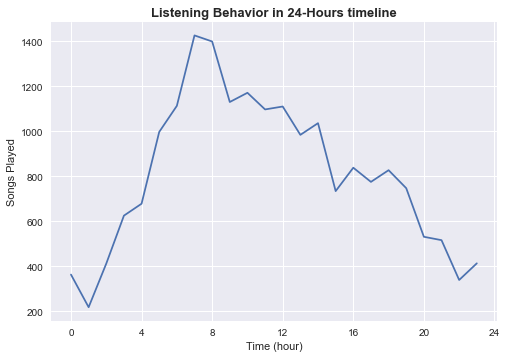

In [23]:
plt.style.use('seaborn')
bins = [0,4,8,12,16,20,24]
plt.plot(listen_time.Hour,listen_time.Song_counts)
plt.title('Listening Behavior in 24-Hours timeline',fontdict={'fontweight':'bold','fontsize': 13})
plt.xlabel('Time (hour)')
plt.xticks(bins)
plt.ylabel('Songs Played')
plt.show()

Surprisingly, it turn out that i tend to streaming spotify in the morning than the rest. 